In [1]:
import matplotlib.pyplot as plt
import pywt
import numpy as np

from tabulated_wvt import TabulatedFunc, TabulatedWavelet

In [2]:
wvt = pywt.Wavelet("sym8")
SCALE = 1 * 4
NSTEPS = 10 * 4
phi, _ = TabulatedWavelet(wvt).get_phi_psi(5)
phi_k = phi.scale(1 / SCALE)
SHIFT = -(phi.xx.max() - phi.xx.min() + NSTEPS - 1) / 2

xx = np.linspace(-5, 5, 1001)
potential = TabulatedFunc(xx, xx**2 / 2)


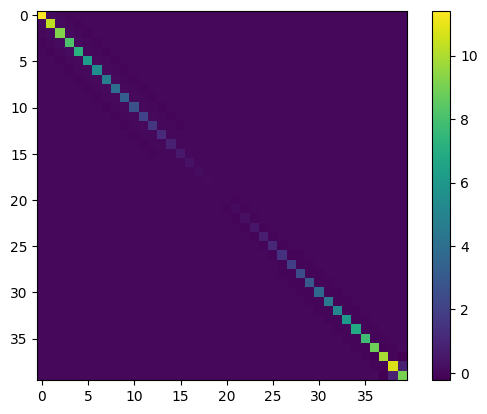

In [3]:
V_mat = np.array([
    [
        (phi_k.shift((SHIFT + i) / SCALE) * phi_k.shift((SHIFT + j) / SCALE) * potential).int().yy[-1]
        for j in range(NSTEPS)
    ] for i in range(NSTEPS)
])
assert np.allclose(V_mat, V_mat.T)

plt.imshow(V_mat)
plt.colorbar();

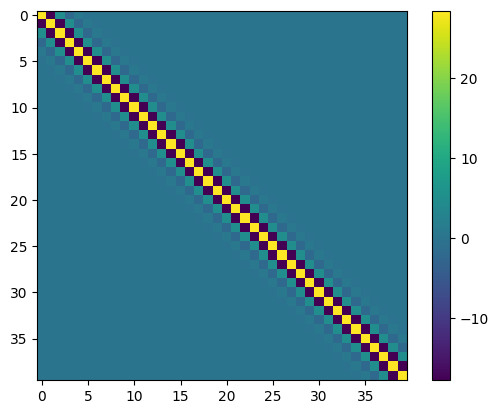

In [4]:
T_mat = np.array([
    [
        (-0.5) * (phi_k.shift((SHIFT + i) / SCALE) * phi_k.shift((SHIFT + j) / SCALE).der().der()).int().yy[-1]
        for j in range(NSTEPS)
    ] for i in range(NSTEPS)
])
assert np.allclose(T_mat, T_mat.T)

plt.imshow(T_mat)
plt.colorbar();

In [5]:
H_mat = V_mat + T_mat

energies, states = np.linalg.eigh(H_mat)

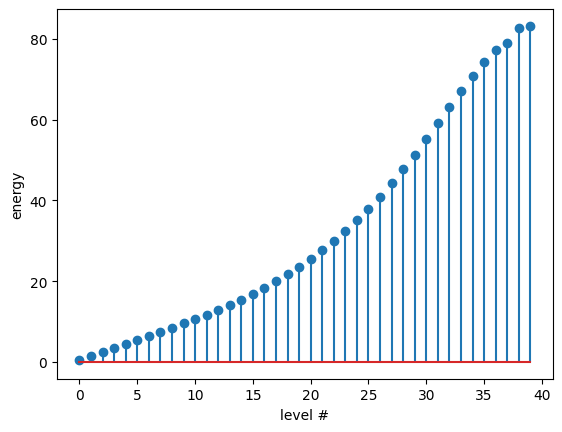

In [6]:
plt.stem(energies)
plt.xlabel("level #")
plt.ylabel("energy");

In [7]:
energies[:6] # correct values are [1/2 + n]

array([0.50000531, 1.49999769, 2.49998253, 3.49996046, 4.49993631,
       5.49994259])

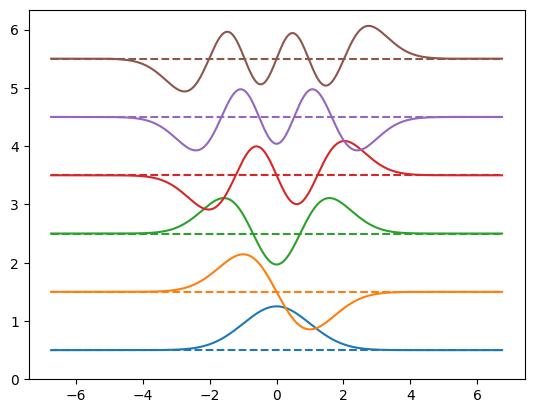

In [8]:
for n in range(6):
    result_func = (sum(phi_k.shift((SHIFT + i) / SCALE) * c for i, c in enumerate(states[:, n]))) + energies[n]
    line, = result_func.plot();
    plt.plot([result_func.xx[0], result_func.xx[-1]], [energies[n], energies[n]], "--", color=line.get_color())
plt.ylim(bottom=0);